In [8]:
import pandas as pd
import os
import re
import io
import datetime as dt
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils import resample
#from autoviz.AutoViz_Class import AutoViz_Class

In [9]:
df=pd.read_csv("US_Accidents_dataset.csv")
ds=df.copy()

# Descripción del dataset

# Integración y selección

Tras una primera exploracion descriptiva y una lectura comprensiva del significado de cada variable, podemos ver que es posible
seleccionar un subconjunto de variables con el que trabajar. 

In [10]:
df.head(5)

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.108910,-83.092860,40.112060,-83.031870,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,2,2016-02-08 05:56:20,2016-02-08 11:56:20,39.865420,-84.062800,39.865010,-84.048730,0.747,At OH-4/OH-235/Exit 41 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-3,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.102660,-84.524680,39.102090,-84.523960,0.055,At I-71/US-50/Exit 1 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Day
3,A-4,2,2016-02-08 06:51:45,2016-02-08 12:51:45,41.062130,-81.537840,41.062170,-81.535470,0.123,At Dart Ave/Exit 21 - Accident.,...,False,False,False,False,False,False,Night,Night,Day,Day
4,A-5,3,2016-02-08 07:53:43,2016-02-08 13:53:43,39.172393,-84.492792,39.170476,-84.501798,0.500,At Mitchell Ave/Exit 6 - Accident.,...,False,False,False,False,False,False,Day,Day,Day,Day


In [11]:
buf = io.StringIO()
df.info(buf=buf)
s = buf.getvalue()
lines = [line.split() for line in s.splitlines()[6:-2]]
info=pd.DataFrame(lines,columns=["d","Variable","Tipo"]).drop("d", axis=1)
info

,Variable,Tipo
0,Severity,int64
1,Start_Time,object
2,End_Time,object
3,Start_Lat,float64
4,Start_Lng,float64
5,End_Lat,float64
6,End_Lng,float64
7,Distance(mi),float64
8,Description,object
9,Number,float64


In [12]:
df.shape

(2845342, 47)

##### Columns tipo Bool
Empezando con las variables tipo bolean podemos ver que las 13 variables no estan balanceadas, todas tienen mas de un 98% de frecuencia para el valor "False". Por lo tanto estas variables pueden ser eliminadas ya que no aportan informacion relevante.

Como se aplicamos una subseleccion con .iloc

In [13]:
#Variable Bool
describe=df.describe(include="bool").T
describe["freq"]=describe["freq"].apply(lambda x: round(100*(x/df.shape[0])))
describe

,count,unique,top,freq
Amenity,2845342,2,False,99
Bump,2845342,2,False,100
Crossing,2845342,2,False,93
Give_Way,2845342,2,False,100
Junction,2845342,2,False,90
No_Exit,2845342,2,False,100
Railway,2845342,2,False,99
Roundabout,2845342,2,False,100
Station,2845342,2,False,98
Stop,2845342,2,False,98


In [14]:
#Eliminacion
bool_idx=[x for x in df.dtypes!="bool"]
df=df.iloc[:, bool_idx]

##### Columns tipo Object

Se observa que muchas de las columnas de este tipo estan desbalanceadas, tiene un 70% de frecuencia para una de los factores. Por lo tanto los eliminaremos las columnas ['Country', 'Astronomical_Twilight', 'Civil_Twilight', 'Sunrise_Sunset', 'Nautical_Twilight', 'Side']


Por otro lado, hay otras columnas que carecen de significado para el analisis que se va a realizar por lo cual tambien se eliminaran. Estas son las siguientes [Timezone,ID,Description,County]

In [15]:
#Variable object
describe=df.describe(include="object").T.sort_values(by=["unique"])
describe

,count,unique,top,freq
Country,2845342,1,US,2845342
Astronomical_Twilight,2842475,2,Day,2176983
Civil_Twilight,2842475,2,Day,1929103
Sunrise_Sunset,2842475,2,Day,1811935
Nautical_Twilight,2842475,2,Day,2063472
Side,2845342,3,R,2353309
Timezone,2841683,4,US/Eastern,1221927
Wind_Direction,2771567,24,CALM,433622
State,2845342,49,CA,795868
Weather_Condition,2774706,127,Fair,1107194


In [16]:
Object_drop=describe.loc[describe["unique"]<=3,["freq"]].apply(lambda x: 100*(x/df.shape[0])).index.tolist()
df.drop(Object_drop,inplace=True,axis=1)

toDrop=["Timezone","ID","Description","County"]
df.drop(toDrop,inplace=True,axis=1)

##### Coulmns tipo numeric
De las columnas tipo numericas solo tenemos que eliminar Number ya que pose mas de un 90% de NANs


In [17]:
#Variable numericas
describe=df.describe().T
describe["count"]=describe["count"].apply(lambda x: round(100*(x/df.shape[0])))
describe

,count,mean,std,min,25%,50%,75%,max
Severity,100,2.137572,0.478722,1.000000,2.000000,2.000000,2.000000,4.000000e+00
Start_Lat,100,36.245201,5.363797,24.566027,33.445174,36.098609,40.160243,4.900058e+01
Start_Lng,100,-97.114633,18.317819,-124.548074,-118.033113,-92.418076,-80.372431,-6.711317e+01
End_Lat,100,36.245321,5.363873,24.566013,33.446278,36.097987,40.161049,4.907500e+01
End_Lng,100,-97.114387,18.317632,-124.545748,-118.033331,-92.417718,-80.373383,-6.710924e+01
Distance(mi),100,0.702678,1.560361,0.000000,0.052000,0.244000,0.764000,1.551860e+02
Number,39,8089.408114,18360.093995,0.000000,1270.000000,4007.000000,9567.000000,9.999997e+06
Temperature(F),98,61.793556,18.622629,-89.000000,50.000000,64.000000,76.000000,1.960000e+02
Wind_Chill(F),83,59.658231,21.160967,-89.000000,46.000000,63.000000,76.000000,1.960000e+02
Humidity(%),97,64.365452,22.874568,1.000000,48.000000,67.000000,83.000000,1.000000e+02


In [18]:
df.drop(["Number"],inplace=True,axis=1)

##### Transformacion de columnas

In [19]:
df['Month'] = pd.to_datetime(df["Weather_Timestamp"]).apply(lambda x: dt.datetime.date(x).month)
df['Time'] = pd.to_datetime(df["Weather_Timestamp"]).apply(lambda x: dt.datetime.time(x).hour)
df['Year'] = pd.to_datetime(df["Weather_Timestamp"]).apply(lambda x: dt.datetime.date(x).year)
df['Duration'] =  pd.to_datetime(df['End_Time'])-pd.to_datetime(df['Start_Time'])
df['Duration'] = df['Duration'].apply(lambda x:round(x.total_seconds()/60) )
df.drop(["Weather_Timestamp","End_Time","Start_Time"],axis=1,inplace=True)

def mappers(df):
    horas=[list(range(x-6,x)) for x in  range(6,30,6)]
    rangos=["0-5","6-11","12-17","18-23"]
    mapTime = {j:i  for e,i in zip(horas,rangos) for j in e}
    df['Time']=df['Time'].map(mapTime)
    
    mapMonth={m:calendar.month_name[m] for m in range(1,13)}
    df['Month']=df['Month'].map(mapMonth)
    
    mapWind={'SW':"SW", 'WSW':"W", 'West':"W", 'NNW':"N", 'WNW':'W', 'NW':'NW', 'W':'W', 'SSW':"S", 'East':"E", 'SE':'SE',
    'North':"N", 'ENE':'E', 'NNE':"N", 'NE':'NE', 'SSE':"S", 'CALM':"C", 'South':"S", 'ESE':"E", 'S':'S',
    'Variable':"V", 'VAR':"V", 'N':"N", 'E':"E"}
    df['Wind_Direction']=df['Wind_Direction'].map(mapWind)
    
    return df

df=mappers(df)

Como resultado nos quedaremos con 21 columnas de 47.  

['Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Street', 'State', 'Zipcode', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition']

# Limpieza de los datos

##### 3.1 ¿Los datos contienen ceros o elementos vacíos? Gestiona cada uno de estos casos

In [20]:
Nan_Columns=pd.DataFrame(df.isna().sum().sort_values(ascending=False),columns=["NANs"])
Nan_Columns=Nan_Columns.loc[Nan_Columns["NANs"]!=0,["NANs"]]
Nan_Columns["Porcentage"]=  round(100*(Nan_Columns["NANs"]/df.shape[0]))
NanList=Nan_Columns.index.tolist()
Nan_Columns

,NANs,Porcentage
Precipitation(in),549458,19.0
Wind_Chill(F),469643,17.0
Wind_Speed(mph),157944,6.0
Wind_Direction,150309,5.0
Humidity(%),73092,3.0
Weather_Condition,70636,2.0
Visibility(mi),70546,2.0
Temperature(F),69274,2.0
Pressure(in),59200,2.0
Airport_Code,9549,0.0


Se observo en el bloque anterior que habia missing values en el aiport_code y aunque es una de las columnas a eliminar porque no son necesarias para el analisis posterior si que la vamos a usar para eliminar registros de condiciones climatologicas como Precipitation. Esto se decidio asi ya que si no hay registro de condiciones meteorologicas para un accidente no podemos usarlos para el analisis de agrupacion o regresion.

Por otro lado las variables Precipitation(in) y Wind_Chill(F) tiene un porcentage de NaNs de casi un 20%, un valor muy alto para una inputacion. Por lo cual optaremos por eliminar esas filas. 

In [21]:
def CountNans(df):
    Nan_Columns=pd.DataFrame(df.isna().sum().sort_values(ascending=False),columns=["NANs"])
    Nan_Columns=Nan_Columns.loc[Nan_Columns["NANs"]!=0,["NANs"]]
    Nan_Columns["Porcentage"]=  100*(Nan_Columns["NANs"]/df.shape[0])
    NanList=Nan_Columns.index.tolist()
    print(Nan_Columns)
    
    return NanList

In [22]:
df=df.dropna(subset=['Airport_Code',"Precipitation(in)","Wind_Chill(F)","City"])
NanList=CountNans(df)

                   NANs  Porcentage
Visibility(mi)     6739    0.302797
Weather_Condition  6531    0.293451
Humidity(%)        3201    0.143827
Pressure(in)       1445    0.064927
Wind_Direction       14    0.000629
Street                1    0.000045


Vamos a imputar los valores con una media una ventana movil en un rango de una hora. Para dicha imputacion se tendra que cargar el dataset otra vez y clasificar los valores por estado y horas. Esto se hara para Visibility(mi), Weather_Condition, Humidity(%), Pressure(in)

In [23]:
toImp=["Visibility(mi)", "Humidity(%)", "Pressure(in)"]
for i in toImp:
    df[i] = df.groupby(["City","Month","Time"])[i].transform(lambda x:x.fillna(x.mean()))

In [24]:
NanList=CountNans(df)

                   NANs  Porcentage
Weather_Condition  6531    0.293451
Visibility(mi)     1097    0.049290
Humidity(%)         259    0.011637
Pressure(in)        130    0.005841
Wind_Direction       14    0.000629
Street                1    0.000045


Tras la imputacion vemos que no hay demasiados valores con NaNs y que representan un valor insingnificante de porcentage. Por lo cual procedemos simplemente a eliminar esas filas

In [25]:
df=df.dropna(subset=['Visibility(mi)',"Humidity(%)","Pressure(in)","Wind_Direction","Weather_Condition","Wind_Direction"])

##### 3.2. Identifica y gestiona los valores extremos.


Visualizamos como se distribuyen los factores de severity a lo largo del dataset. Como se vera en el plot la clase no esta balanceada. 

Los valores atípicos en los datos categóricos también pueden atribuirse al problema del desequilibrio de clases. Esto significa que los datos para cada clase no están en una proporción similar. En tal situación, utilizaremos tecnicas de muestreo, concretamente Muestra aleatoria simple con sustitución

In [26]:
df.Severity.value_counts()

2    2066877
3      64824
4      62733
1      23581
Name: Severity, dtype: int64

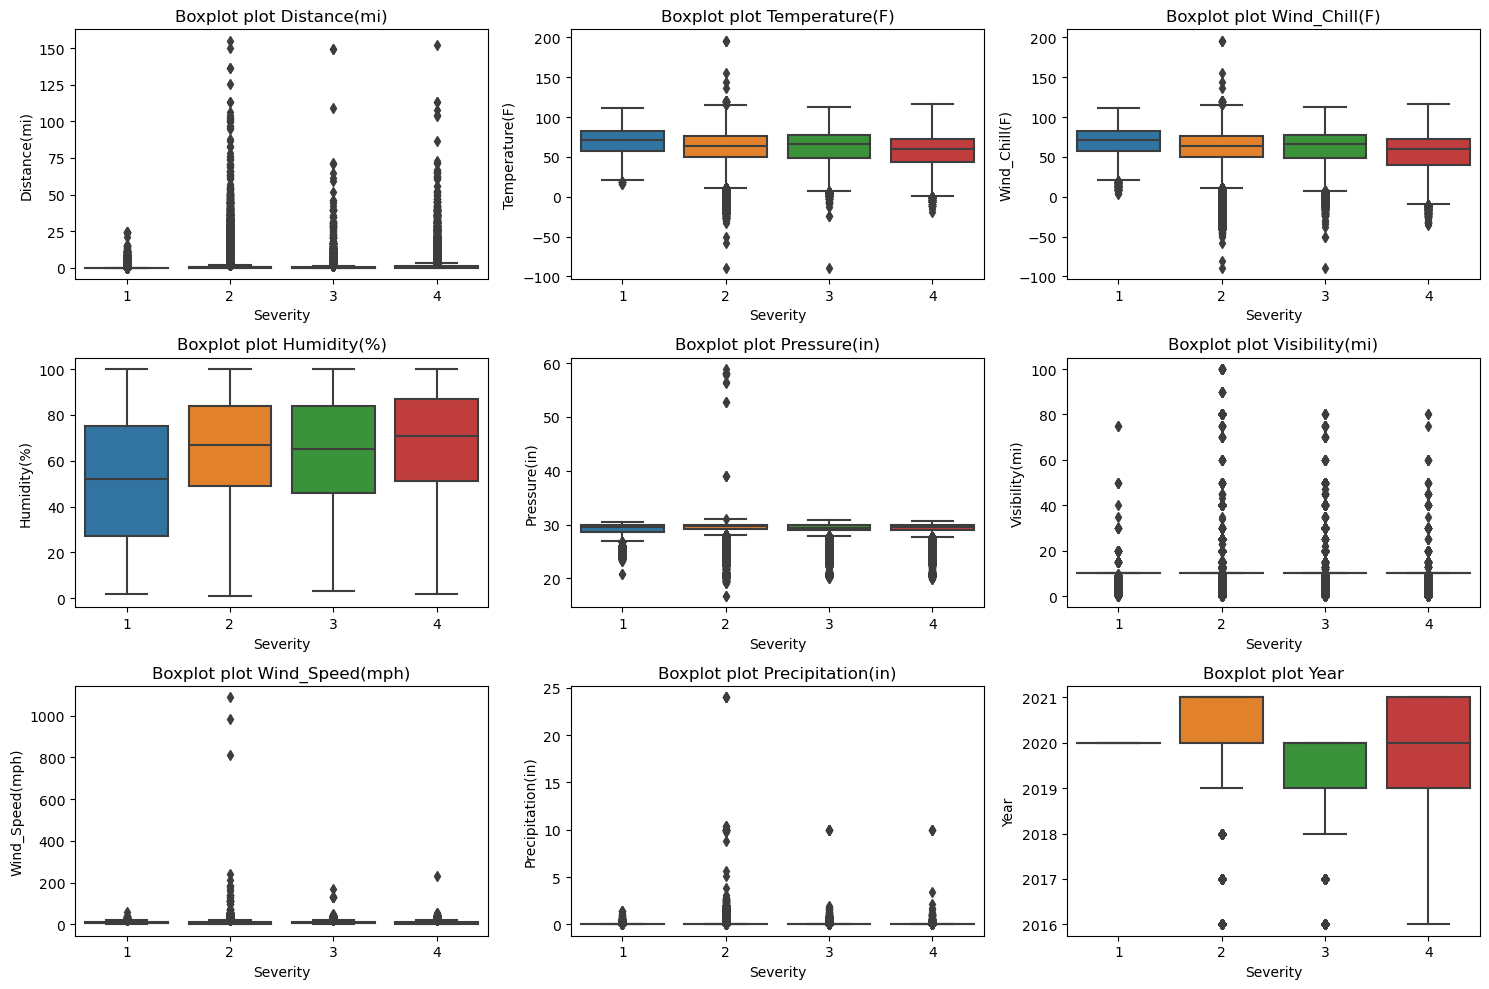

In [27]:
def BoxPLotOutlier(df):
    tmp=df.select_dtypes(include='number')
    tmp=tmp.loc[:, ~tmp.columns.isin(['Start_Lat', 'Start_Lng','End_Lat', 'End_Lng'])]
    cols=list(tmp.columns)[1:]
    
    fig, axis = plt.subplots(3,3,figsize=(15, 10))
    for ax,c in zip(axis.reshape(-1),cols):
        ax.set_title("Boxplot plot {}".format(c))
        sns.boxplot(x="Severity", y=c, data=tmp,ax=ax)
    plt.tight_layout()
    plt.show()

BoxPLotOutlier(df)

In [28]:
def Sampling(df):
    
    seed=234    
    s1 = df[df["Severity"] == 1]
    s2 = df[df["Severity"] == 2]
    s3 = df[df["Severity"] == 3]
    s4 = df[df["Severity"] == 4]

    s2_downsample = resample(s2,replace=True,n_samples=len(s1),random_state=seed)
    s3_downsample = resample(s3,replace=True,n_samples=len(s1),random_state=seed)
    s4_downsample = resample(s4,replace=True,n_samples=len(s1),random_state=seed)
    df=pd.concat([s1, s2_downsample,s3_downsample,s4_downsample]).reset_index(drop=True)
    
    return df

df=Sampling(df)
df=df.reset_index(drop=True)
df.Severity.value_counts()

1    23581
2    23581
3    23581
4    23581
Name: Severity, dtype: int64

<AxesSubplot:xlabel='Severity', ylabel='count'>

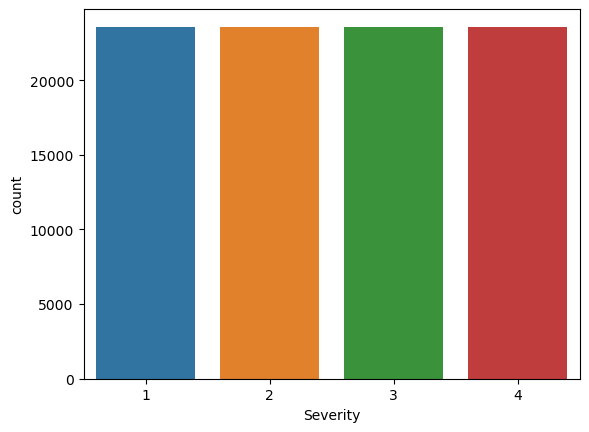

In [29]:
sns.countplot(x="Severity", data=df)

A continuacion visualizamos las variables independientes numericas contra la severidad para ver por una parte si las clases estan balanceadas respecto a las variables independientes, y por otro lado usaremos un boxplot para tomar la decision sobre que se puede considerar un valor extremo.

Para ciertas variables consideraremos outliers todo lo que se encuentra alejado 3 desviaciones estándar con respecto a la media del conjunto es un outlier.

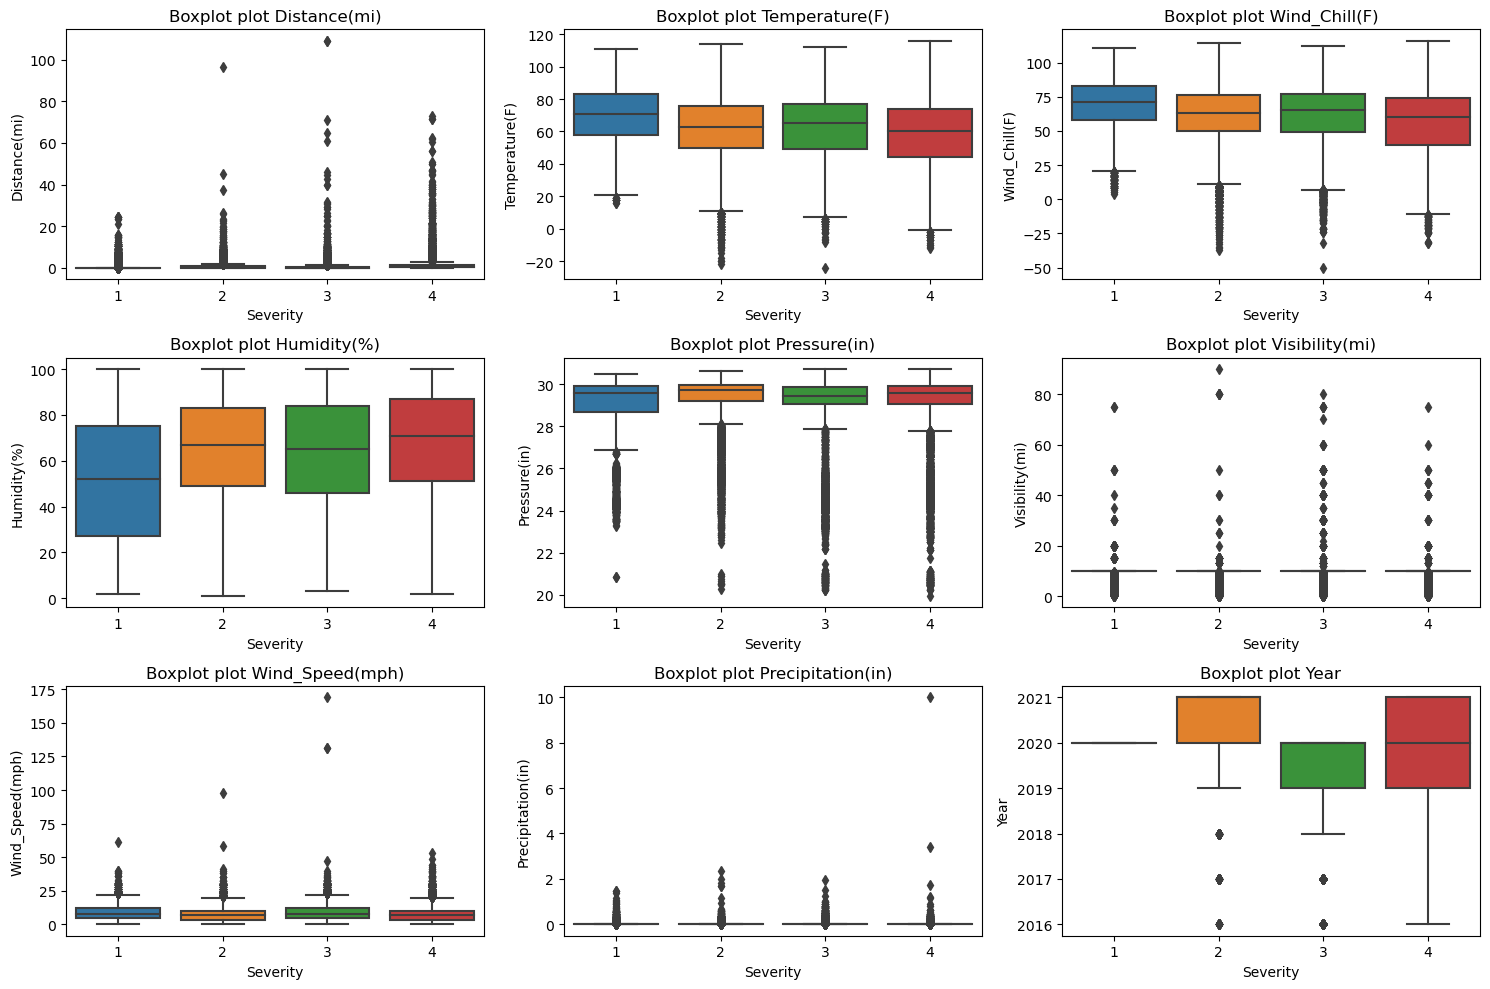

In [30]:
BoxPLotOutlier(df)

<Figure size 2000x600 with 0 Axes>

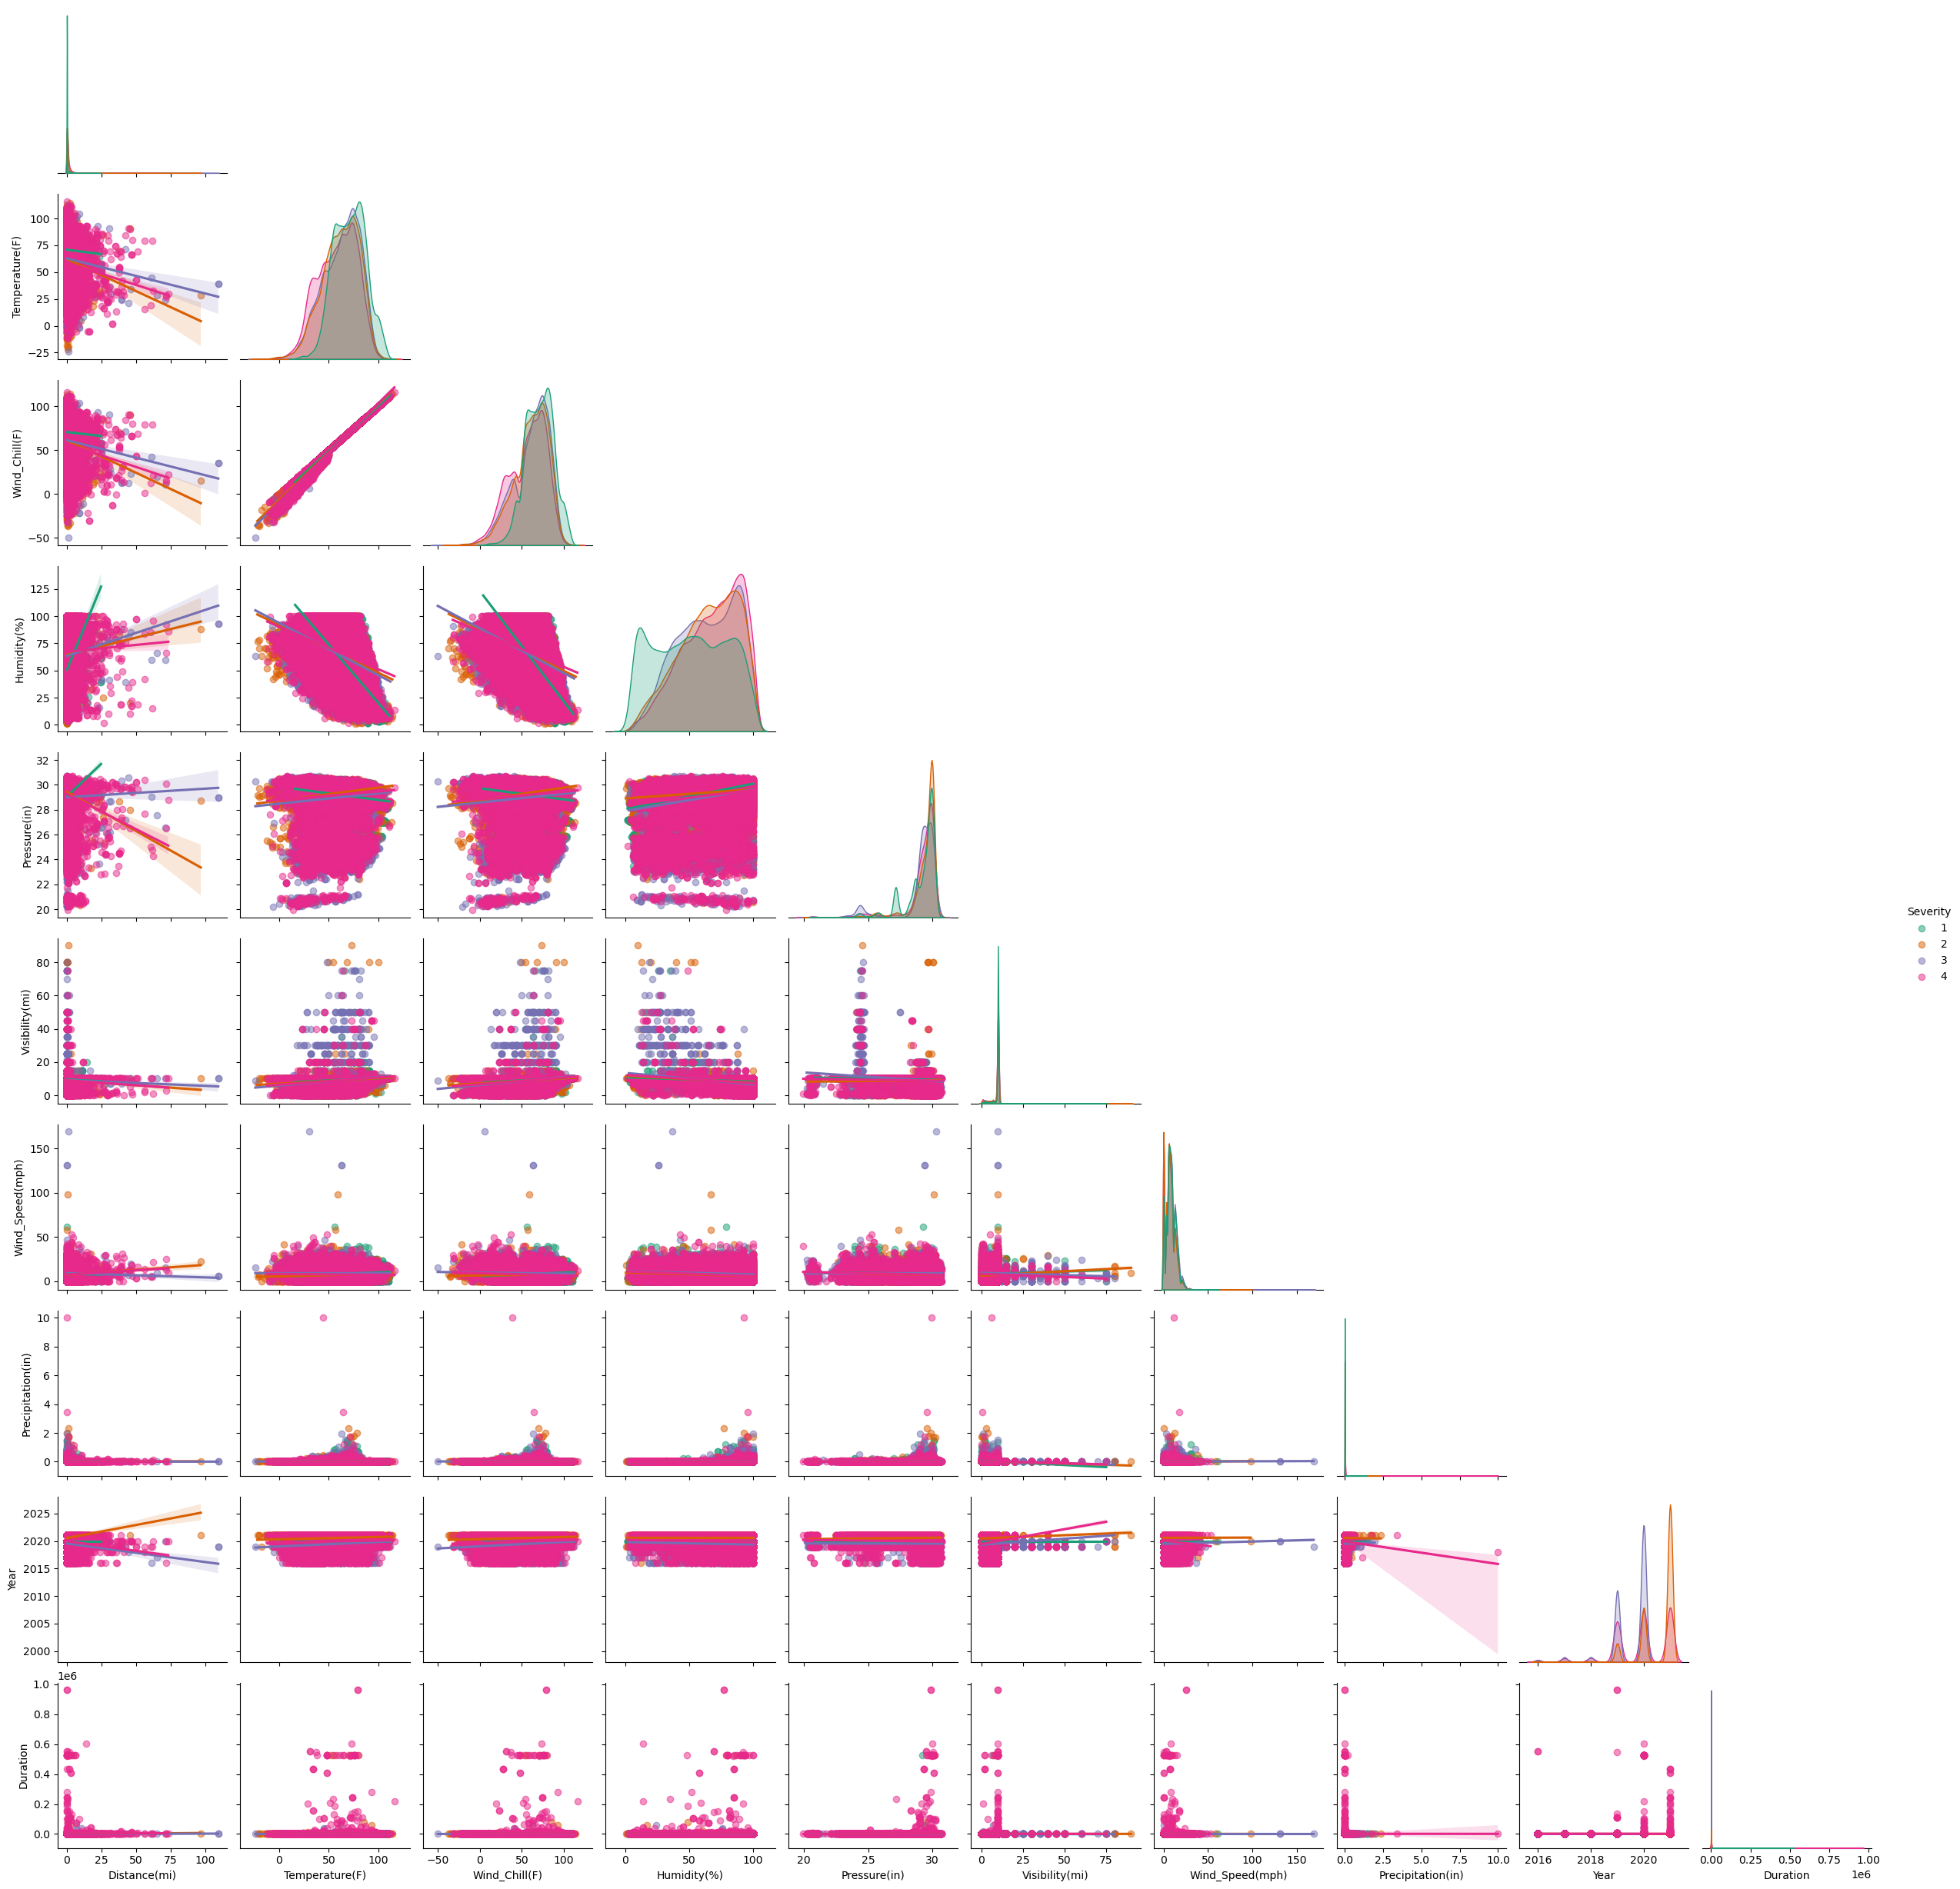

In [31]:
def PairPlot(df):
    tmp=df.select_dtypes(include='number')
    tmp['Severity']=tmp['Severity'].astype(object)
    tmp=tmp.loc[:, ~tmp.columns.isin(['Start_Lat', 'Start_Lng','End_Lat', 'End_Lng'])]
    plt.figure(figsize = (20, 6))
    sns.pairplot(tmp,hue="Severity",corner=True,kind='reg',diag_kind="kde",palette='Dark2',plot_kws={'scatter_kws': {'alpha': 0.5}})
PairPlot(df)

In [32]:
def remove_outliers(df,name):
    #Percentil
    q25,q75=np.percentile(df[name],25),np.percentile(df[name],75)
    #Interquartile range
    iqr=1.5*(q75-q25)
    #Limites
    lower,upper=q25-iqr,q75+iqr
    #Remove the outliers
    df=df[(df[name] >= lower) & (df[name] <= upper)]
    return df

df = remove_outliers(df,name='Temperature(F)')
df = remove_outliers(df,name='Wind_Chill(F)')
df = remove_outliers(df,name='Humidity(%)')
df = remove_outliers(df,name='Pressure(in)')
df = remove_outliers(df,name='Wind_Speed(mph)')

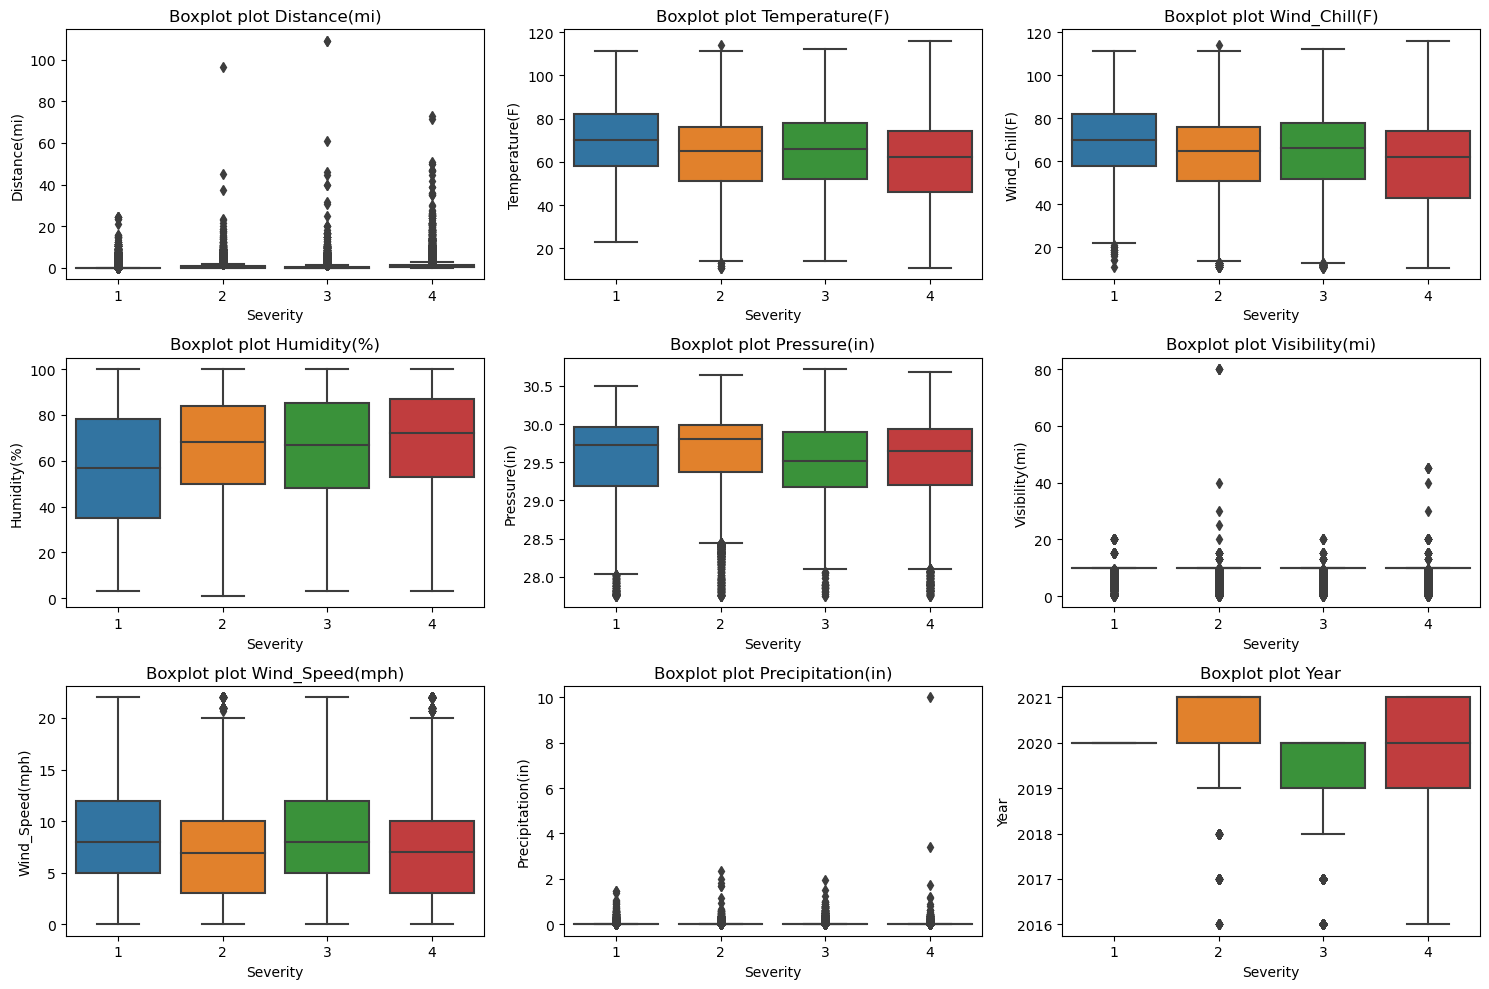

In [33]:
BoxPLotOutlier(df)

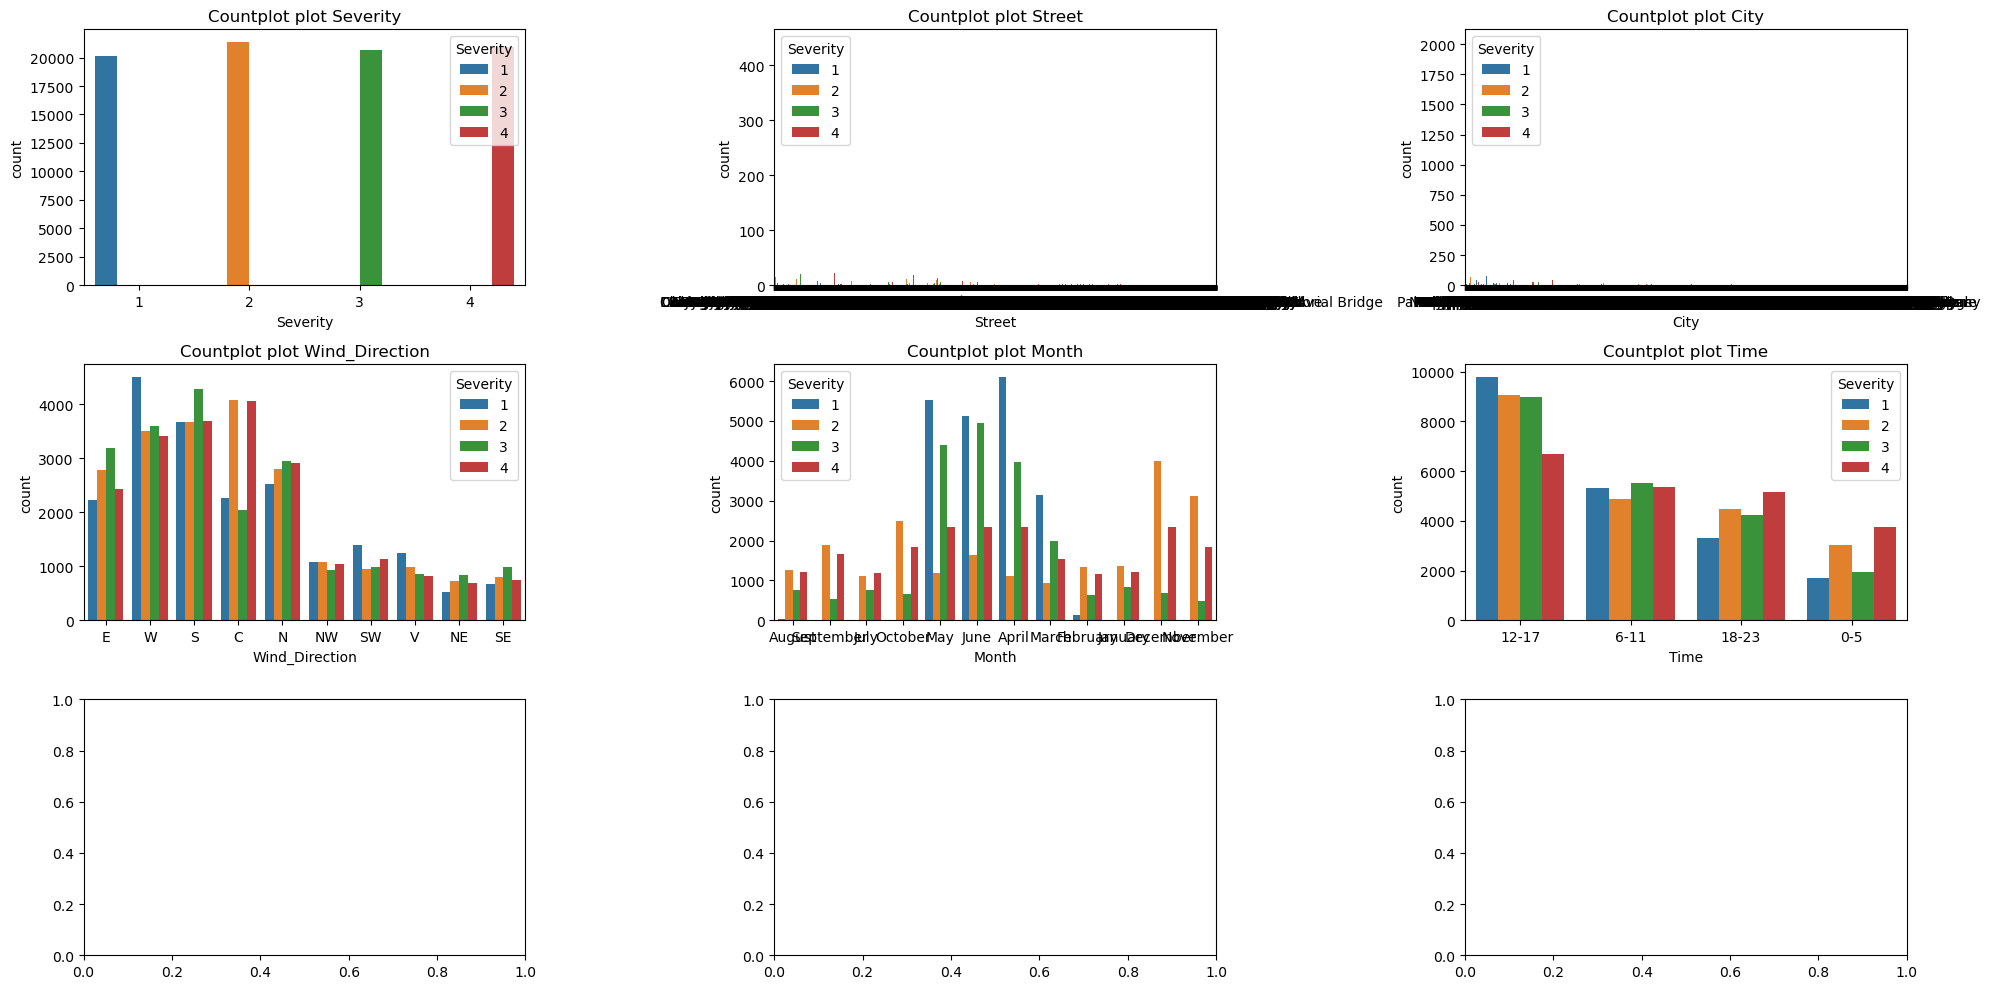

In [34]:
def CountPlotOutlier(df):
    var=["Severity",'Street', 'City', 'Wind_Direction', 'Month', 'Time']
    tmp=df.loc[:,var]
    
    fig, axis = plt.subplots(3,3,figsize=(20, 10))
    for ax,c in zip(axis.reshape(-1),var):
        ax.set_title("Countplot plot {}".format(c))
        sns.countplot(hue="Severity", x=c, data=tmp,ax=ax)
    plt.tight_layout()
    plt.show()

CountPlotOutlier(df)

Vemos que hay una gran cantidad de outliers sobre todo para  los accidentes con severidad 2. Se va a limpiar los outliers usando la desviacion estandart y luego se volvera a comparar.

In [35]:
df.columns

Index(['Severity', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng',
       'Distance(mi)', 'Street', 'City', 'State', 'Zipcode', 'Airport_Code',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Month', 'Time', 'Year',
       'Duration'],
      dtype='object')

# Análisis de los datos

##### 4.1. Selección de los grupos de datos que se quieren analizar/comparar (p.ej., si se van a comparar grupos de datos, ¿cuáles son estos grupos y qué tipo de análisis se van a aplicar?)



Análisis de los factores que influyen en la severidad. Correlaciones y regresión logística multinomial.

In [50]:
# Función para normalizar dataframe
def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
df_new = df[['Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)','Precipitation(in)', 'Weather_Condition']]

df_new.head()

,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition
2,0.0,68.0,68.0,93.0,29.14,9.0,E,5.0,0.02,Light Rain with Thunder
3,0.0,98.0,98.0,18.0,28.28,10.0,W,5.0,0.00,Fair
4,0.0,95.0,95.0,22.0,29.90,10.0,W,9.0,0.00,Fair
5,0.0,81.0,81.0,79.0,29.20,10.0,S,7.0,0.01,Mostly Cloudy
6,0.0,71.0,71.0,81.0,27.81,10.0,C,0.0,0.00,Partly Cloudy


<AxesSubplot:>

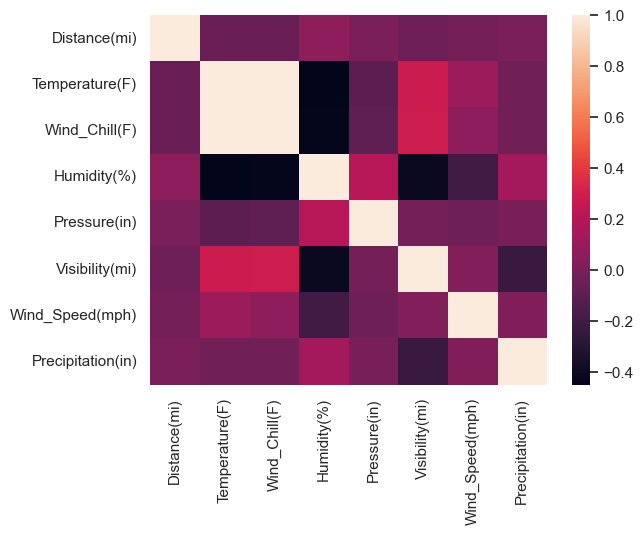

In [73]:
# Calculamos la matriz de correlación para las variables numéricas y las visualizamos con la librería seaborn
df_numerical = df_new[['Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Speed(mph)','Precipitation(in)']]

df_normalizado = mean_norm(df_numerical)

corr = df_normalizado.corr()

sns.heatmap(corr)

In [74]:
pd.DataFrame(corr)

,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
Distance(mi),1.000000,-0.053888,-0.057526,0.068994,0.001495,-0.036577,-0.014219,0.002098
Temperature(F),-0.053888,1.000000,0.994832,-0.447813,-0.097641,0.279483,0.114223,-0.031880
Wind_Chill(F),-0.057526,0.994832,1.000000,-0.432616,-0.088786,0.285641,0.071549,-0.031853
Humidity(%),0.068994,-0.447813,-0.432616,1.000000,0.207449,-0.409717,-0.195245,0.139950
Pressure(in),0.001495,-0.097641,-0.088786,0.207449,1.000000,-0.014960,-0.036661,-0.002785
Visibility(mi),-0.036577,0.279483,0.285641,-0.409717,-0.014960,1.000000,0.032860,-0.228823
Wind_Speed(mph),-0.014219,0.114223,0.071549,-0.195245,-0.036661,0.032860,1.000000,0.027097
Precipitation(in),0.002098,-0.031880,-0.031853,0.139950,-0.002785,-0.228823,0.027097,1.000000


Tras normalizar los datos y calcular los coeficientes de correlación observamos como *Temperature(F)* y *Wind_Chill(F)* están totalmente correlacionados.

A continuación comprobaré como se correlacionan las variables categóricas *weather_condition* y *wind_direction* con el resto de variables numéricas por medio del cálculo de ANOVAs.

In [82]:
def multiple_anovas(df, cat_item, num_item):
    from scipy.stats import f_oneway
    category_list = df.groupby(cat_item)[num_item].apply(list)
    anova_result = f_oneway(*category_list)
    print(f'P-value for {cat_item} and {num_item} ANOVA is {anova_result[1]}')
    if anova_result[1] < 0.05:
        print('Rejected H0, both are correlated (95%)')
    else:
        print('Acepted H0, both are not correlated (95%)')

In [85]:
print('ANOVAs for "Wind_Direction"')
multiple_anovas(df_new, 'Wind_Direction', 'Distance(mi)')
multiple_anovas(df_new, 'Wind_Direction', 'Temperature(F)')
multiple_anovas(df_new, 'Wind_Direction', 'Wind_Chill(F)')
multiple_anovas(df_new, 'Wind_Direction', 'Humidity(%)')
multiple_anovas(df_new, 'Wind_Direction', 'Pressure(in)')
multiple_anovas(df_new, 'Wind_Direction', 'Visibility(mi)')
multiple_anovas(df_new, 'Wind_Direction', 'Wind_Speed(mph)')
multiple_anovas(df_new, 'Wind_Direction', 'Precipitation(in)')
print('ANOVAs for "Weather_Condition"')
multiple_anovas(df_new, 'Weather_Condition', 'Distance(mi)')
multiple_anovas(df_new, 'Weather_Condition', 'Temperature(F)')
multiple_anovas(df_new, 'Weather_Condition', 'Wind_Chill(F)')
multiple_anovas(df_new, 'Weather_Condition', 'Humidity(%)')
multiple_anovas(df_new, 'Weather_Condition', 'Pressure(in)')
multiple_anovas(df_new, 'Weather_Condition', 'Visibility(mi)')
multiple_anovas(df_new, 'Weather_Condition', 'Wind_Speed(mph)')
multiple_anovas(df_new, 'Weather_Condition', 'Precipitation(in)')

ANOVAs for "Wind_Direction"
P-value for Wind_Direction and Distance(mi) ANOVA is 0.0009698818959663366
Rejected H0, both are correlated (95%)
P-value for Wind_Direction and Temperature(F) ANOVA is 0.0
Rejected H0, both are correlated (95%)
P-value for Wind_Direction and Wind_Chill(F) ANOVA is 0.0
Rejected H0, both are correlated (95%)
P-value for Wind_Direction and Humidity(%) ANOVA is 0.0
Rejected H0, both are correlated (95%)
P-value for Wind_Direction and Pressure(in) ANOVA is 0.0
Rejected H0, both are correlated (95%)
P-value for Wind_Direction and Visibility(mi) ANOVA is 1.3614657032668732e-275
Rejected H0, both are correlated (95%)
P-value for Wind_Direction and Wind_Speed(mph) ANOVA is 0.0
Rejected H0, both are correlated (95%)
P-value for Wind_Direction and Precipitation(in) ANOVA is 2.3853159882842742e-29
Rejected H0, both are correlated (95%)
ANOVAs for "Weather_Condition"
P-value for Weather_Condition and Distance(mi) ANOVA is 3.008245014445999e-94
Rejected H0, both are corr

Correlación entre variables categóricas (V de Cramer)

In [88]:
import scipy.stats as ss

def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.to_numpy().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [89]:
confusion_matrix = pd.crosstab(df['Weather_Condition'], df['Wind_Direction'])
cramers_v(confusion_matrix)

0.09187909776290026

Este valor cercano a 0 nos indica la poca correlación entre ambas variables categóricas.

Aplicaré una regresión logística multinomial para comprobar como se relacionan estas variables con la severidad del accidente. Para las variables altamente correlacionadas puede omitirse una de ellas. Para aplicar correctamente regresiones logísticas e interpretarlas se ha seguido lo descrito en el siguiente enlace: https://www.datasklr.com/logistic-regression/multinomial-logistic-regression

In [115]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split

# Elimino la columna Wind_Chill al estar altamente correlacionada con Temperature
X = df_normalizado[['Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Speed(mph)','Precipitation(in)']]
y = df['Severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 5)

# modelo de regresión logística multinomial
model = LogisticRegression(random_state=0, multi_class='multinomial', penalty='none', solver='newton-cg')

model.fit(X_train, y_train)

preds = model.predict(X_test)

params = model.get_params()
print(params)

print('Intercept: \n', model.intercept_)
print('Coefficients: \n', model.coef_)

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'multinomial', 'n_jobs': None, 'penalty': 'none', 'random_state': 0, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Intercept: 
 [-0.1858605   0.09412966  0.05948249  0.03224835]
Coefficients: 
 [[-0.89047859  0.24517351 -0.22080022  0.01487199  0.00944449  0.0267688
   0.06632657]
 [ 0.289521   -0.04395237 -0.01822734  0.17092279 -0.00632528 -0.15513689
  -0.04530324]
 [ 0.08232358  0.01360294  0.09834129 -0.1109083  -0.05450122  0.21179947
   0.05813984]
 [ 0.51863401 -0.21482409  0.14068626 -0.07488648  0.05138201 -0.08343138
  -0.07916317]]


In [116]:
np.exp(model.coef_)

array([[0.41045927, 1.27784301, 0.80187687, 1.01498312, 1.00948923,
        1.0271303 , 1.06857562],
       [1.3357875 , 0.95699954, 0.98193777, 1.18639915, 0.99369468,
        0.85629795, 0.95570763],
       [1.08580709, 1.01369589, 1.10333928, 0.89502082, 0.94695735,
        1.23590003, 1.0598632 ],
       [1.67973158, 0.80668333, 1.15106346, 0.92784881, 1.05272497,
        0.91995421, 0.92388916]])

In [120]:
import statsmodels.api as sm
logit_model = sm.MNLogit(y_train, sm.add_constant(X_train))
logit_model
result = logit_model.fit()
stats1 = result.summary()
stats2 = result.summary2()
print(stats1)
print(stats2)

Optimization terminated successfully.
         Current function value: 1.311815
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:               Severity   No. Observations:                66498
Model:                        MNLogit   Df Residuals:                    66474
Method:                           MLE   Df Model:                           21
Date:                Thu, 05 Jan 2023   Pseudo R-squ.:                 0.05358
Time:                        21:47:11   Log-Likelihood:                -87233.
converged:                       True   LL-Null:                       -92171.
Covariance Type:            nonrobust   LLR p-value:                     0.000
       Severity=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2800      0.013     20.816      0.000       0.254       0.306
Distance

In [127]:
print(X_test.columns)

Index(['Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)'],
      dtype='object')


Se coge como clase base la severidad nivel 1. A partir de esta se crean tres conjuntos de coeficientes para evaluar e interpretar las *odds* de que la severidad sea la clase base o la que se compara con esta. Cada coeficiente se corresponde con las variables introducidas en el modelo. En el primer caso (Severity = 0), aunque algo confuso, se está comparando la severidad de nivel 1 con la de nivel 2. La distancia en millas tiene un p-valor inferior a 0.05 por lo que es significativo a la hora de predecir la severidad del accidente. Además, tiene un coeficiente de 1.18 en este caso y esto implica que por cada milla que aumente la distancia el accidente es 1.18 veces más posible que el accidente sea de severidad 2.

##### 4.2. Comprobación de la normalidad y homogeneidad de la varianza.


##### 4.3. Aplicación de pruebas estadísticas para comparar los grupos de datos. En función de los datos y el objetivo del estudio, aplicar pruebas de contraste de hipótesis, correlaciones, regresiones, etc. Aplicar al menos tres métodos de análisis diferentes.